In [8]:
import sys
sys.path.append('..')

In [15]:
import numpy as np
from matplotlib import pyplot as plt

from qca.util.util import normalize, plot_x
from qca.chain_qw.exp2 import Exp2
from qca.util.potential_builders import get_step_V, get_smeared_V

In [16]:
def get_ck(psi, sign):
    ck = []
    for n in range(-L, L):
        psi_k = normalize(qw.free_eigenfun(sign=sign, k=np.pi/L*n))
        ck.append(psi.T.conj() @ psi_k)
    return np.array(ck)
    
def decompose_in_k(psi, k0):
    ck_plus = get_ck(psi, sign=1)
    ck_minus = get_ck(psi, sign=-1)
    norm = sum(np.abs(ck_plus)**2) + sum(np.abs(ck_minus)**2)
    assert abs(norm-1) < 1e-3, norm
    plt.xlabel('k')
    plt.ylabel(r'$\vert{c_k}\vert^2$')
    plt.title('Mode decomposition')
    plt.xticks([k0, k0-np.pi, -k0, -k0+np.pi], [r'$k_0$', r'$k_0-\pi$', r'$-k_0$', r'$\pi-k_0$'])
    p = plt.plot(np.arange(-L, L)*np.pi/L, np.abs(ck_plus)**2+np.abs(ck_minus)**2)
    return p

In [17]:
EPS = 1e-9

# A first possible experiment

We consider a closed chain of length $2L$, positions are labelled by $x=-L, \dots, L-1$. The QW walk is given by $U=W^2V$ with
$$
W = \begin{pmatrix}
    \nu T^\dagger & -i\mu\\
    -i\mu & \nu T
\end{pmatrix}\,,
$$
and 
$$
V = \sum_{z\in \mathbb{Z}}\begin{pmatrix}
    1 & 0\\
    0 & e^{i\gamma\delta_{x,0}}
\end{pmatrix}\otimes \lvert x\rangle \langle x \rvert\,.
$$
Above, $T\lvert x\rangle = \lvert x+1\rangle$ is the translation operator, $\mu, \nu\ge 0$ with $\mu^2+\nu^2=1$. 

Consider the eigenproblem $U\lvert\psi\rangle = e^{i\omega} \lvert\psi\rangle$. Generically, we have 4 solutions to this equation labelled by momenta $(k, k-\pi, -k, -k+\pi)$.

## Unreasonable resources

First, we consider the simulation of a scattering through the potential without thinking about experimental constraints. In particular, we consider long evolution times and rather broad wavepackets. The goal is to show the phenomenon we'd like to see in the lab.

Some observations:
- The pick in momentum space are the furthest apart when $k_0=\pi/4$;
- The strongest the interaction the better;
- The more massive is the walker, the more the effect is pronounced, so ideally we would like to stay as close as possible to $\theta=np.pi/2$. However, this comes at a price: the more massive is the walker, the slower it moves. 

Taking into account the observations above, we find that a good choice of parameters is $L=300$, $\theta=2\pi/5$, $\gamma=\pi$, $k_0=\pi/4$. 

In [81]:
L = 300
gamma = np.pi
V0 = np.array([[1, 0],
            [0, np.exp(1j*gamma)]])
V = get_step_V(L=L, V0=V0, a=0, b=0)
theta = 3*np.pi/5
nw = 2
qw = Exp2(L=L, theta=theta, nw=nw, V=V)

We prepare an initial gaussian packet localized at $x_0=-100$ travelling to the right with momentum close to $k_0=\pi/4$ ($\sigma_k=0.1$). We will track the evolution of the wavepacket as it scatters on the potential. 

We will see that the scattering excites modes with momenta $k_0-\pi$ and $\pi-k_0$, not only $-k_0$. This is the same physics found for the Thirring QCA [[Bisio et al. 2018]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.032132), and it's what we'd like to observe. 

In [109]:
k0 = np.pi/4
sigma_k = 0.1
x0 = -100
sign = -1
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=sign))

The evolution looks like this.

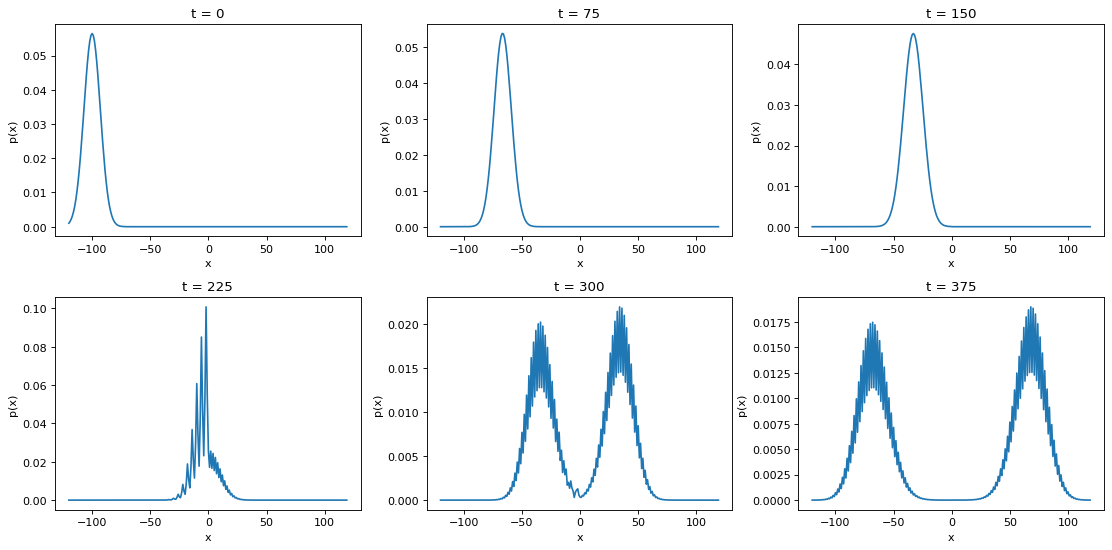

In [110]:
steps = 5
step_size = 75
fig = plt.figure(figsize=(14, 10), dpi=80)
fig.add_subplot(3, 3, 1)
x_max = 120
plot_x(qw, -x_max, x_max)
plt.title(f't = 0')
for i in range(steps):
    qw.evolve(step_size)
    fig.add_subplot(3, 3, i+2)
    plot_x(qw, -x_max, x_max)
    plt.title(f't = {step_size*(i+1)}')
fig.tight_layout()
plt.savefig('scatter_pos_theory.pdf',bbox_inches='tight')
plt.show()

After the scattering with the potential, we have two wavepackets, corresponding to transmitted and reflected waves. 

The oscillating behaviour on small scales is due to the interference between modes with momenta $k_0$ and $k_0-\pi$, and $-k_0$ and $-k_0+\pi$. Observing this interference pattern is one possible way to show that modes with momenta $k_0-\pi$ and $-k_0+\pi$ are excited. 

Another way it to decompose the outcoming signal in the momentum eigenbasis.

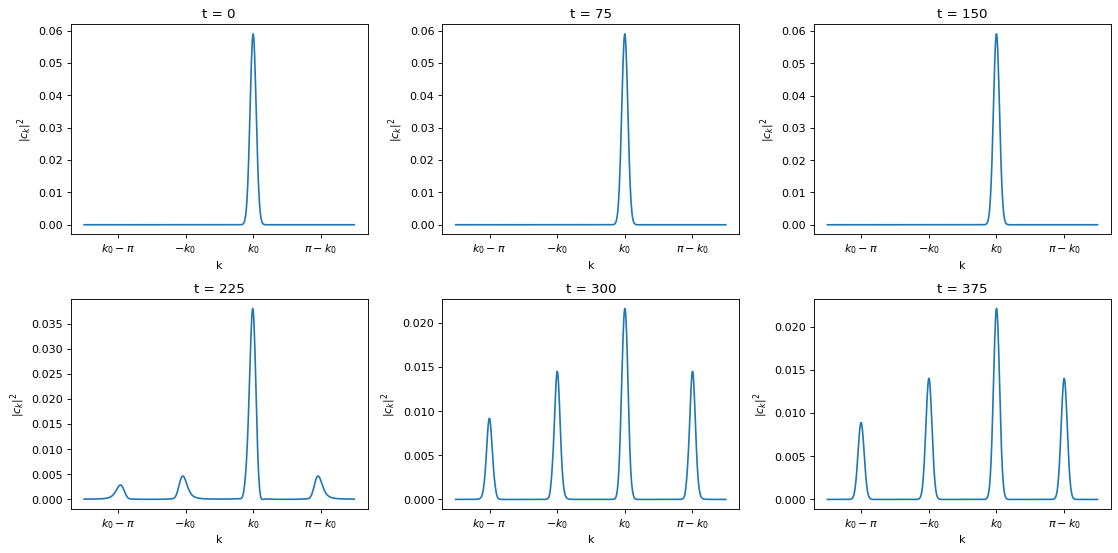

In [113]:
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=sign))
fig = plt.figure(figsize=(14, 10), dpi=80)
fig.add_subplot(3, 3, 1)
decompose_in_k(qw.psi, k0)
plt.title(f't = 0')
steps = 5
for i in range(steps):
    qw.evolve(step_size)
    fig.add_subplot(3, 3, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {step_size*(i+1)}')
fig.tight_layout()
plt.savefig('scatter_mom_theory.pdf',bbox_inches='tight')
plt.show()

We see that the signal, initially prepared with a momentum picked at $k_0$, develops 3 other picks after scattering with the potential.

## Reasonable resources

We try to find parameters for which the interference pattern is still visible, while satisfying the experimental constraints. In particular, we try to minimize the number of time steps necessary to see the interference pattern.

### First try

We choose the following parameters: $L=100$, $\theta=\pi/4$, $\gamma=\pi$, $k_0=\pi/4$, $\sigma_k=0.3$, and $x_0=-3.5$.

In [114]:
L = 100
theta = np.pi/4
nw = 2
k0 = np.pi/4
sigma_k = 0.3
x0 = -3.5
steps = 5

First consider the model without interaction.

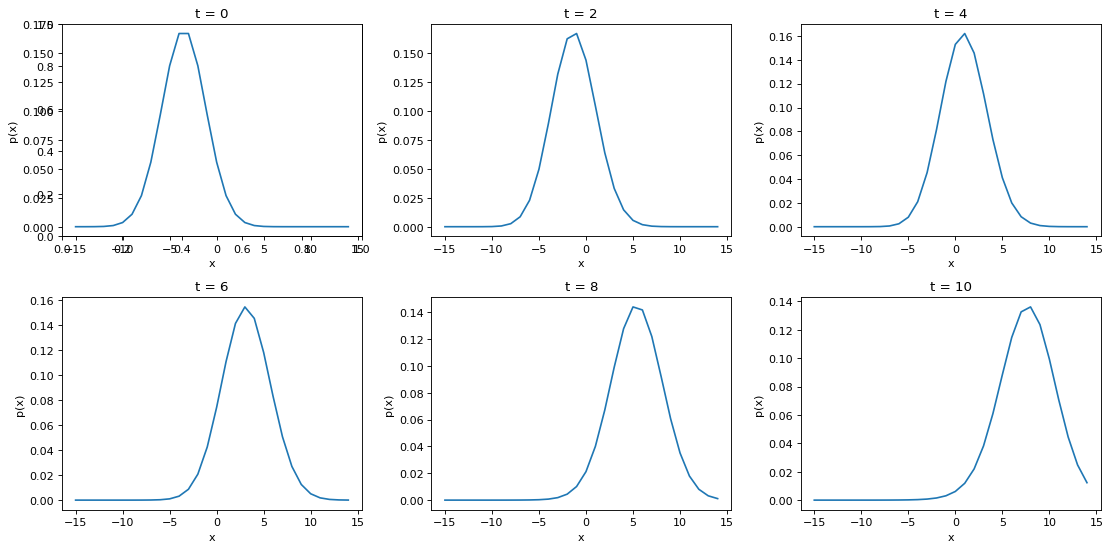

In [116]:
qw = Exp2(L=L, theta=theta, nw=nw, V=None)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
fig = plt.figure(figsize=(14, 10), dpi=80)
fig.add_subplot(3, 3, 1)
fig.add_subplot(3, 3, 1)
plot_x(qw, -3*steps, 3*steps)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 3, i+2)
    plot_x(qw, -3*steps, 3*steps)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.savefig('scatter_pos_exp_2.pdf',bbox_inches='tight')
plt.show()

The point here is that the wavepacket is small enough (and fast enough), that it has the time to go completely from one side of $x=0$ to the other. 

We now introduce the interaction, $\gamma = \pi$.

In [120]:
gamma = np.pi
V0 = np.array([[1, 0],
            [0, np.exp(1j*gamma)]])
V = get_step_V(L=L, V0=V0, a=0, b=0)

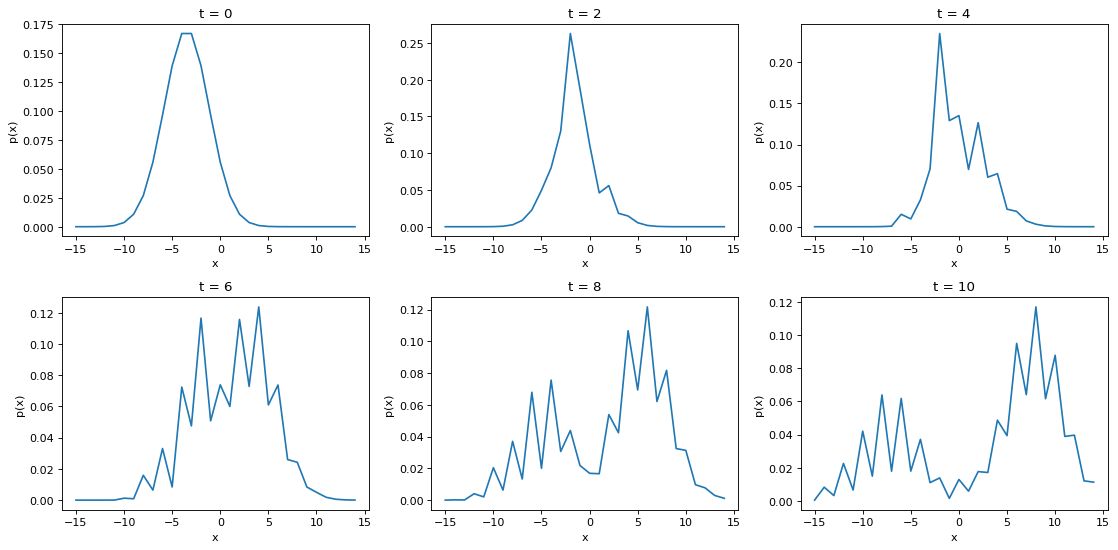

In [121]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
#plt.figure(figsize=(10, 6), dpi=80)
fig = plt.figure(figsize=(14, 10), dpi=80)
fig.add_subplot(3, 3, 1)
plot_x(qw, -3*steps, 3*steps)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 3, i+2)
    plot_x(qw, -3*steps, 3*steps)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.savefig('scatter_pos_exp_2.pdf',bbox_inches='tight')
plt.show()

We also consider the same scattering process in momentum space.

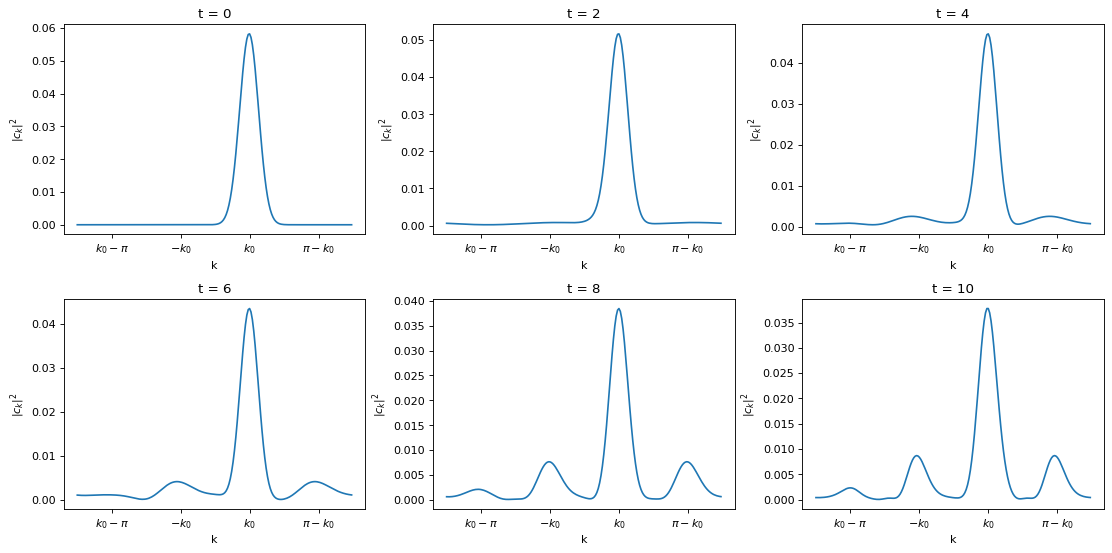

In [123]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
ps = []
fig = plt.figure(figsize=(14, 10), dpi=80)
fig.add_subplot(3, 3, 1)
decompose_in_k(qw.psi, k0)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 3, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.savefig('scatter_mom_exp_2.pdf',bbox_inches='tight')
plt.show()

### Second try

The main reason why the visibility in the previous example is poor is that, due to the limited available evolution time, we need to consider a light walker. One way around this problem is to modify the evolution operator to $U=W^4V$. 

In [45]:
L = 100
theta = 3*np.pi/5
nw = 4
k0 = np.pi/4
sigma_k = 0.4
x0 = -4
steps = 5

First consider the model without interaction.

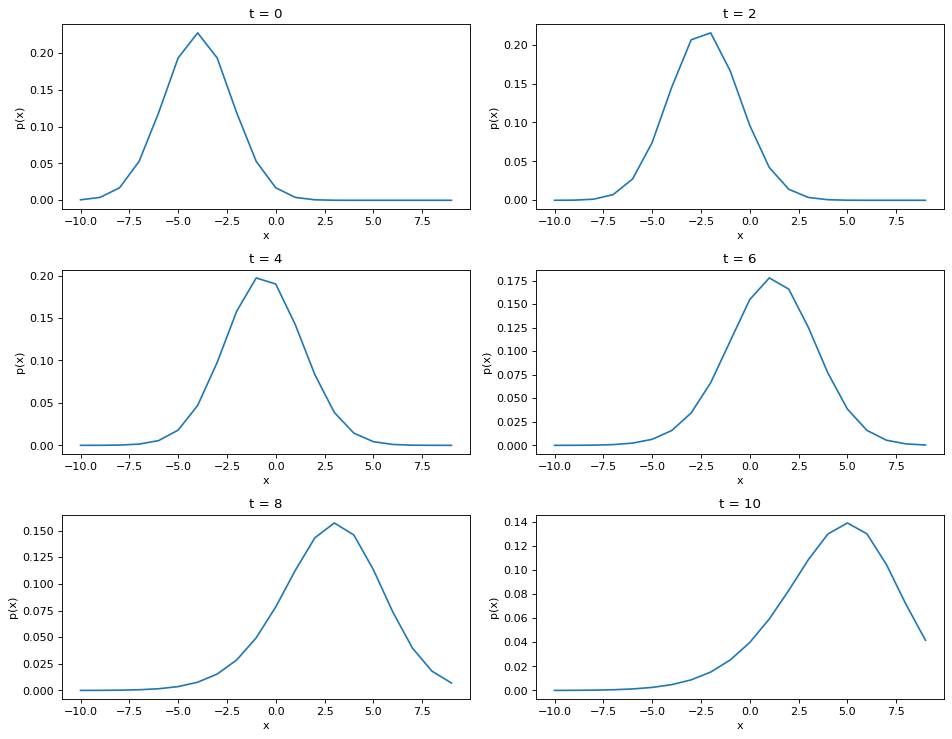

In [46]:
qw = Exp2(L=L, theta=theta, nw=nw, V=None)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
fig = plt.figure(figsize=(12, 12), dpi=80)
n_h = int((steps+1)/2)+1
fig.add_subplot(n_h, 2, 1)
plot_x(qw, -10, 10)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(n_h, 2, i+2)
    plot_x(qw, -10, 10)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

We now introduce the interaction, $\gamma = \pi$.

In [48]:
gamma = np.pi
V0 = np.array([[1, 0],
            [0, np.exp(1j*gamma)]])
V = get_step_V(L=L, V0=V0, a=0, b=0)

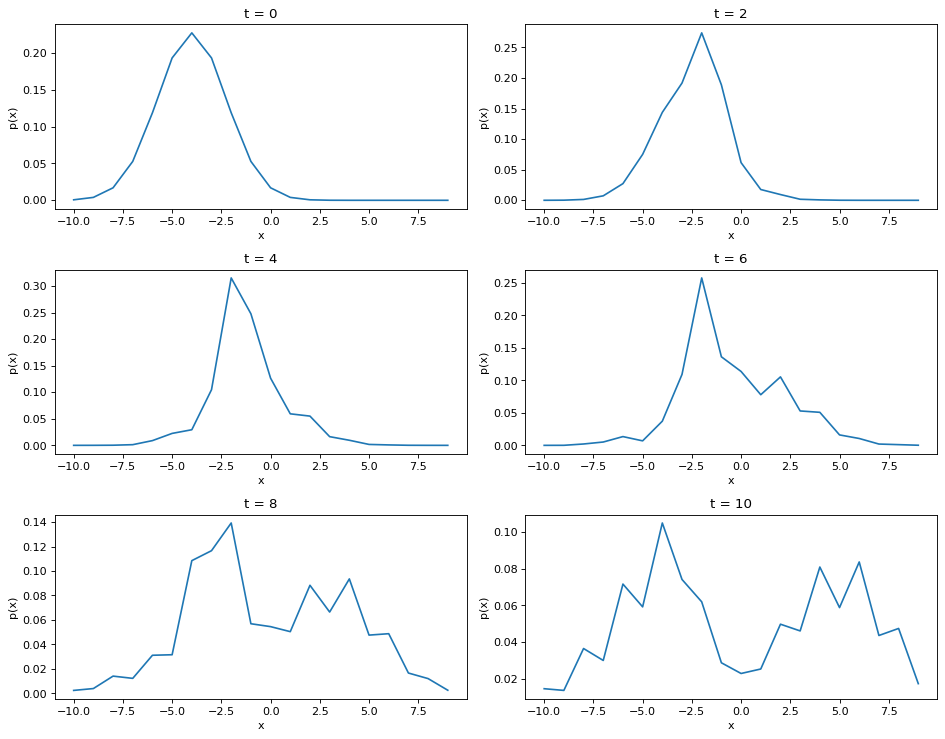

In [49]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
#plt.figure(figsize=(10, 6), dpi=80)
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(n_h, 2, 1)
plot_x(qw, -10, 10)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(n_h, 2, i+2)
    plot_x(qw, -10, 10)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

We see that the packet has enough time to split in two separate wavepackets (reflected and transmitted), and the interference patterns are clearly visible.

We also consider the same scattering process in momentum space.

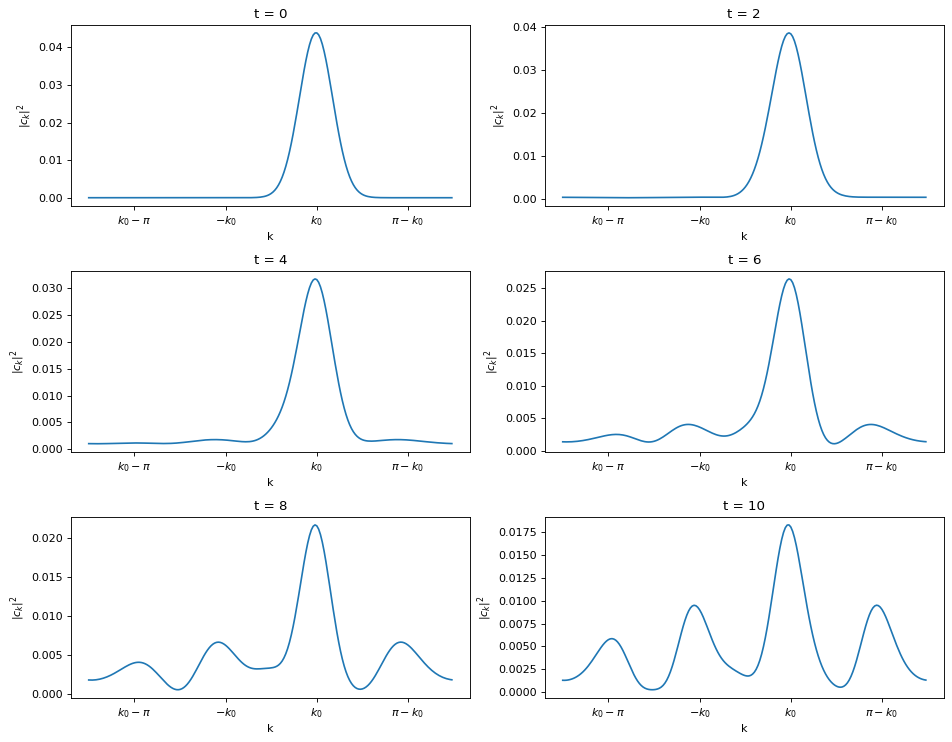

In [50]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
ps = []
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(n_h, 2, 1)
decompose_in_k(qw.psi, k0)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(n_h, 2, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

### Smearing the interaction

We check how much the final result is affected by a smearing in the interaction.

#### $W^2$

In [125]:
L = 100
theta = np.pi/4
nw = 2
k0 = np.pi/4
sigma_k = 0.3
x0 = -3.5
steps = 5

In [126]:
gamma = np.pi
get_V = lambda gamma: np.array(
    [[1, 0],
    [0, np.exp(1j*gamma)]])
sigma_V = 1
# we renormalise gamma to take into account the gaussian envelop
ren_gamma = gamma/(sigma_V*np.sqrt(2*np.pi))
V = get_smeared_V(L=L, get_V=get_V, phi=ren_gamma, sigma_V=sigma_V)

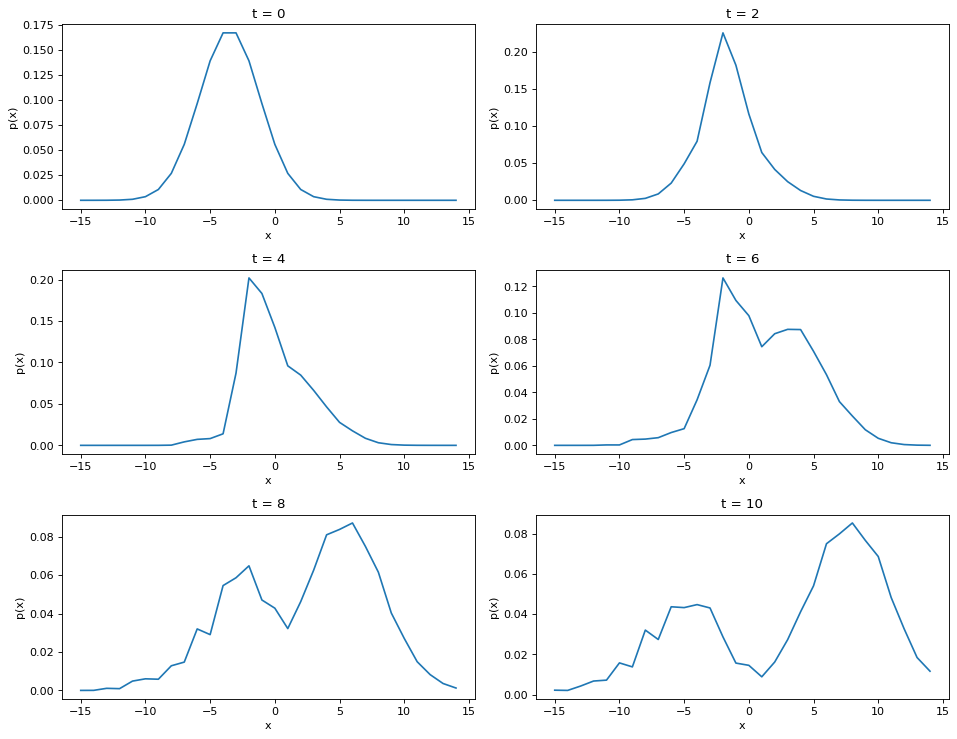

In [40]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
#plt.figure(figsize=(10, 6), dpi=80)
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(n_h, 2, 1)
ymax = 0.2
plot_x(qw, -3*steps, 3*steps)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(n_h, 2, i+2)
    plot_x(qw, -3*steps, 3*steps)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

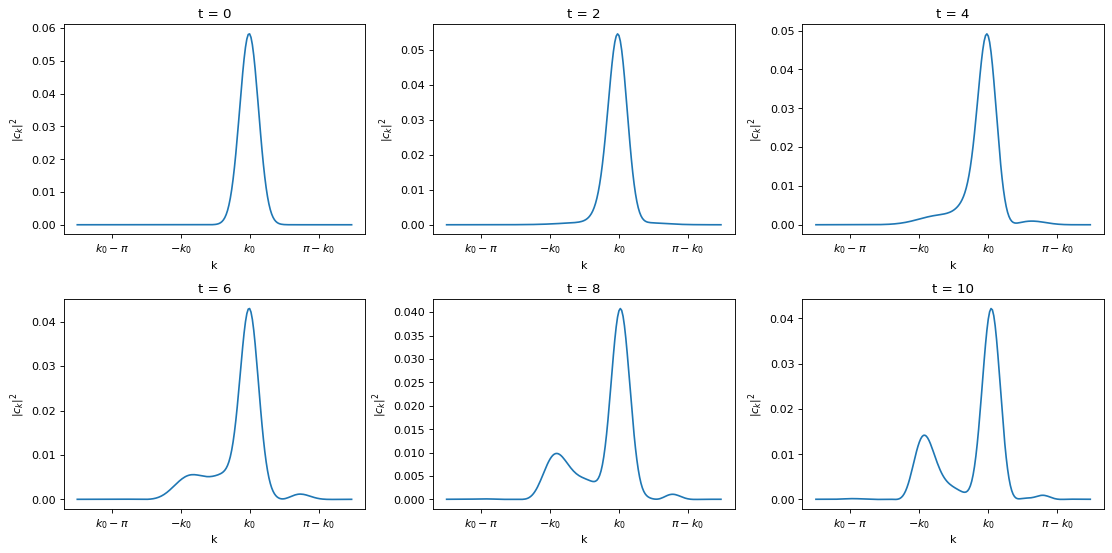

In [128]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
ps = []
fig = plt.figure(figsize=(14, 10), dpi=80)
fig.add_subplot(3, 3, 1)
decompose_in_k(qw.psi, k0)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(3, 3, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.savefig('scatter_pos_exp_2_smeared.pdf',bbox_inches='tight')
plt.show()

#### $W^4$

In [77]:
L = 100
theta = 3*np.pi/5
nw = 4
k0 = np.pi/4
sigma_k = 0.4
x0 = -6
steps = 5
n_h = int((steps+1)/2)+1

In [78]:
gamma = np.pi
get_V = lambda gamma: np.array(
    [[1, 0],
    [0, np.exp(1j*gamma)]])
sigma_V = 1
# we renormalise gamma to take into account the gaussian envelop
ren_gamma = gamma/(sigma_V*np.sqrt(2*np.pi))
V = get_smeared_V(L=L, get_V=get_V, phi=ren_gamma, sigma_V=sigma_V)

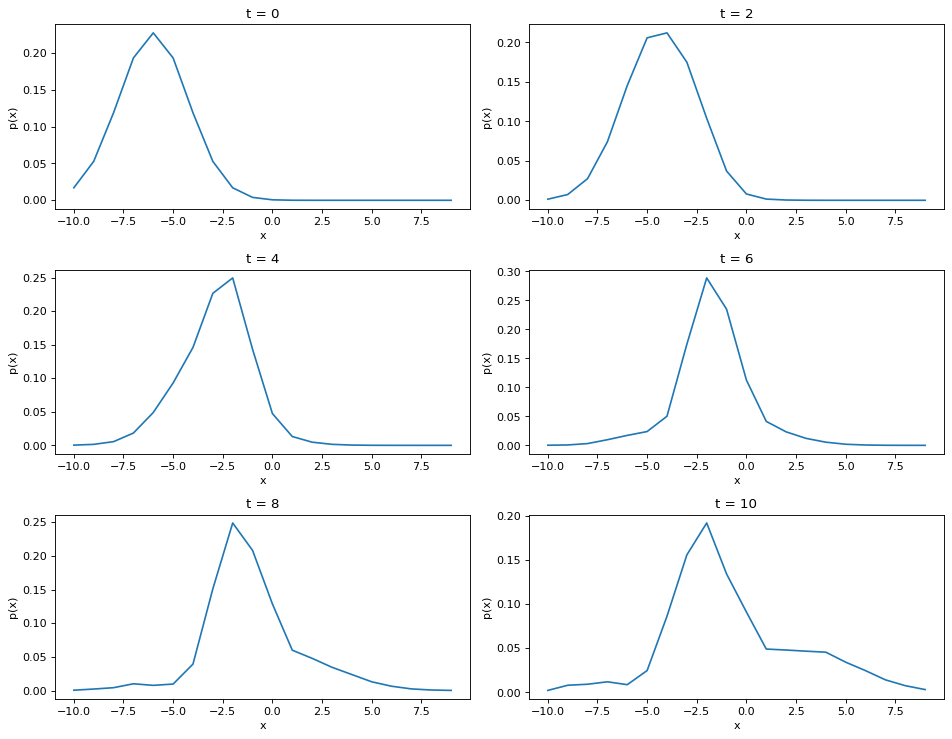

In [79]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
#plt.figure(figsize=(10, 6), dpi=80)
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(n_h, 2, 1)
plot_x(qw, -10, 10)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(n_h, 2, i+2)
    plot_x(qw, -10, 10)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()

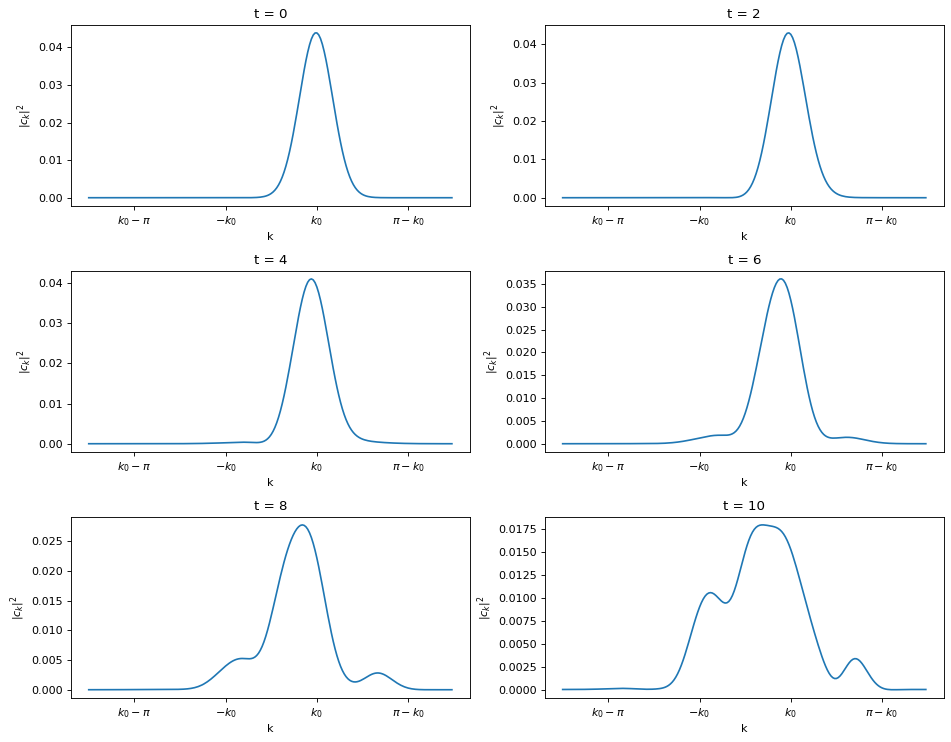

In [80]:
qw = Exp2(L=L, theta=theta, nw=nw, V=V)
qw.psi = normalize(qw.wave_packet(k0=k0, sigma_k=sigma_k, x0=x0, sign=-1))
ps = []
fig = plt.figure(figsize=(12, 12), dpi=80)
fig.add_subplot(n_h, 2, 1)
decompose_in_k(qw.psi, k0)
plt.title('t = 0')
for i in range(steps):
    qw.evolve(2)
    fig.add_subplot(n_h, 2, i+2)
    decompose_in_k(qw.psi, k0)
    plt.title(f't = {2*(i+1)}')
fig.tight_layout()
plt.show()